# Demo on the "most common" regridder

For regridding categorical data to a coarser resolution, normal regridding methods don't work.
This can be data like land cover or vegetation type.

For this reason we implemented a "most common" regridder, which takes the most common value of the source data cells that overlap with the target grid cells.

If you want to regrid data to a finer resolution, the "nearest-neighbor" regridder can be used.

We start with importing the required packages:

In [1]:
import xarray as xr
import xarray_regrid

import dask.distributed

client = dask.distributed.Client()

Next we need a high resolution dataset to regrid. We used the LCCS land cover data which is available from the [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-land-cover).

Note the data is loaded in as a dask arrays, allowing for lazy computation.

In [2]:
ds = xr.open_dataset(
    "/data/C3S-LC-L4-LCCS-Map-300m-P1Y-2020-v2.1.1.nc",
    chunks="auto",
)

da = ds["lccs_class"]  # Only take the class variable.
da = da.sortby(["lat", "lon"])
da = da.rename({"lat": "latitude", "lon": "longitude"})
da

<xarray.DataArray 'lccs_class' (time: 1, latitude: 64800, longitude: 129600)> Size: 8GB
dask.array<getitem, shape=(1, 64800, 129600), dtype=uint8, chunksize=(1, 9257, 10125), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 518kB -90.0 -90.0 -89.99 ... 89.99 90.0 90.0
  * longitude  (longitude) float64 1MB -180.0 -180.0 -180.0 ... 180.0 180.0
  * time       (time) datetime64[ns] 8B 2020-01-01
Attributes:
    standard_name:        land_cover_lccs
    flag_colors:          #ffff64 #ffff64 #ffff00 #aaf0f0 #dcf064 #c8c864 #00...
    long_name:            Land cover class defined in LCCS
    valid_min:            1
    valid_max:            220
    ancillary_variables:  processed_flag current_pixel_state observation_coun...
    flag_meanings:        no_data cropland_rainfed cropland_rainfed_herbaceou...
    flag_values:          [  0  10  11  12  20  30  40  50  60  61  62  70  7...

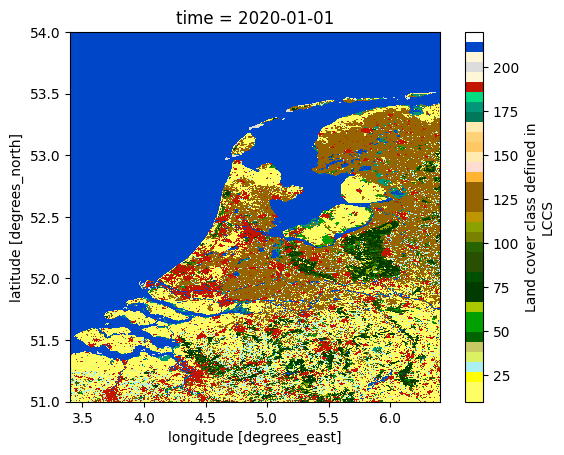

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

colors = da.attrs["flag_colors"].split(" ")
cmap = ListedColormap(colors)

ax = da.sel(latitude=slice(51, 54), longitude=slice(3.4, 6.4)).plot(cmap=cmap, vmin=10, vmax=220)
ax = plt.gca()
ax.set_aspect('equal')

We will also define our target grid:

In [4]:
from xarray_regrid import Grid

target_dataset = Grid(
    north=90,
    east=90,
    south=0,
    west=0,
    resolution_lat=1,
    resolution_lon=1,
).create_regridding_dataset()

The default chunks are a bit large for this regridding operation, so we need to rechunk before continuing to avoid memory issues: 

In [5]:
da = da.chunk({"time": -1, "latitude": 4050, "longitude": 4050})
da.data

dask.array<rechunk-merge, shape=(1, 64800, 129600), dtype=uint8, chunksize=(1, 4050, 4050), chunktype=numpy.ndarray>

Using `regrid.most_common` you can now regrid the data. This is currently only implemented for `DataArray`s, not `xr.Dataset`.

Note that we have to provide the values of the expected labels in the data. This dataset already conventiently stores these in the attributes.

In [6]:
da_regrid = da.regrid.most_common(
    target_dataset, values=da.attrs["flag_values"], time_dim="time"
)

When we call `.plot` on the DataArray, computation will begin.

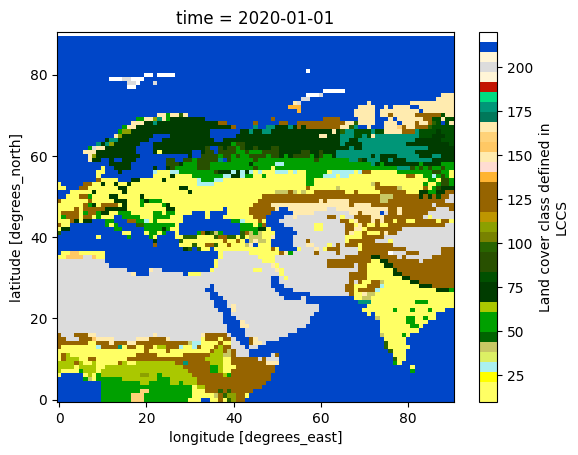

In [7]:
da_regrid.plot(x="longitude", cmap=cmap, vmin=10, vmax=220)